### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 27 апреля 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 27 апреля, -4 балла после 08:30 4 мая, -6 баллов после 08:30 11 мая, -8 баллов после 08:30 18 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator

from tqdm import tqdm

from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

In [3]:
class MyDecisionTreeClassifier(BaseEstimator):
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split = 2, max_depth = 5, criterion = 'gini'):

        A = {'gini': self.__gini, 'entropy': self.__entropy, 'misclass': self.__misclass}
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        self.feature_importances_ = None
        self.criterion = criterion
        self.tree = dict()
#         self.ind = []
        if criterion in A:
            self.F_function = A[criterion]
        else:
            print('invalid')
            raise
            
    def __gini(self, p):
        return 1 - (p**2).sum(axis=0)

    def __entropy(self, p):
        return  - np.sum(np.where(p == 0, 0, p*np.log(p)), axis = 0)

    def __misclass(self, p):
        return 1 - p.max(axis=0)

    def __div_samples(self, x, y, feature_id, threshold):
        left_mask = x[:, feature_id] >= threshold
        right_mask = ~left_mask
        ind = np.arange(x.shape[1]) != feature_id
        return x[left_mask][:, ind], x[right_mask][:, ind], y[left_mask], y[right_mask]
    
    def __sort_samples(self, x, y):
        sorted_idx = x.argsort()
        return x[sorted_idx], y[sorted_idx]
              
    
    def __find_threshold(self, x, y):
        best_crit = - np.inf
        best_feature_id = -1
        best_th = 0
        freq = np.bincount(y, minlength = self.num_class).flatten()
        
        for i in np.arange(x.shape[1]):
            
#             if i in self.ind:
#                 continue
                
            sorted_x, sorted_y = self.__sort_samples(x[:, i], y)

            lblock = np.where(sorted_y[:-1] != sorted_y[1:])[0] + 1
#             lblock1 = np.where((sorted_y[:-1] != sorted_y[1:])&(~np.isclose(sorted_x[:-1], \
#                                                                            sorted_x[1:])))[0] + 1
        
            if lblock.size == 0:
                continue
                
            sizes = lblock.flatten()
            sizes[1:] -= lblock[:-1]

            lfreq = np.zeros(shape=(self.num_class, lblock.size))
            lfreq[sorted_y[lblock - 1], range(lblock.size)] = 1
            lfreq = (lfreq*sizes).cumsum(axis=1)

            rfreq = freq.reshape(-1, 1) - lfreq
            rblock = y.size - lblock

            crit = lblock * self.F_function(lfreq/lblock) + rblock * self.F_function(rfreq/rblock)
            crit = self.F_function(freq.reshape(-1, 1)/y.size) - crit/y.size

            best_split = crit.argmax()
            pos = lblock[best_split]
            
            crit, th = crit[best_split], (sorted_x[pos] + sorted_x[pos - 1])/2
            if crit > best_crit:
                best_crit = crit
                best_feature_id = i
                best_th = th
                if crit > y.size:
                    return best_feature, best_threshold
        return best_crit, best_feature_id, best_th
    
    def __fit_node(self, x, y, node_id, depth):
        freq = np.bincount(y, minlength = self.num_class)
        most_common = freq.argmax()
        if (depth == self.max_depth) or (y.size <= self.min_samples_split) or y.size == freq[most_common]:
            self.tree[node_id] = (self.LEAF_TYPE, most_common, freq[most_common]/y.size)
            return
        
        best_crit, best_feature_id, best_th = self.__find_threshold(x, y)
#         self.ind.append(best_feature_id)
        
        xl, xr, yl, yr = self.__div_samples(x, y, best_feature_id, best_th)
        if xl.size == 0 or xr.size == 0:
            self.tree[node_id] = (self.LEAF_TYPE, most_common, freq[most_common]/y.size)
            return 
        self.tree[node_id] = (self.NON_LEAF_TYPE, best_feature_id, best_th)
        self.feature_importances_[best_feature_id] += best_crit
        self.__fit_node(xl, yl, 2*node_id + 1, depth + 1)
        self.__fit_node(xr, yr, 2*node_id + 2, depth + 1)
    
    def fit(self, x, y):

        self.feature_importances_ = np.zeros(x.shape[1], dtype=np.float)
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 
        self.feature_importances_ /= np.sum(self.feature_importances_)
        return self

    def __predict_class(self, x, node_id):

        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):

        return self.feature_importances_
    
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

In [32]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [33]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [34]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

MyDecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=2)

In [35]:
print(accuracy_score(y_pred = clf.predict(X_test), y_true = y_test))
print(accuracy_score(y_pred = my_clf.predict(X_test), y_true = y_test))

0.7222222222222222
0.7777777777777778


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [36]:
%time clf.fit(X_train, y_train)

CPU times: user 1.92 ms, sys: 264 µs, total: 2.18 ms
Wall time: 1.22 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [37]:
%time my_clf.fit(X_train, y_train)

CPU times: user 9.13 ms, sys: 133 µs, total: 9.26 ms
Wall time: 8.41 ms


MyDecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=2)

## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [38]:
df = pd.read_csv('Speed Dating Data.csv', encoding='latin1')

In [39]:
df = df.iloc[:, :97]

In [40]:
df.head(4)

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1
0,1,1.0,0,1,1,1,10,7,NaN,4,...,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN


In [41]:
df = df.drop(['id', 'idg', 'condtn', 'round', 
              'position', 'positin1', 'order', 'partner',
              'age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o', 'undergra',
              'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming',
              'clubbing', 'reading', 'tv', 'theater', 
              'movies', 'concerts', 'music', 'shopping', 'yoga', 
              'expnum', 'from', 'zipcode', 'field', 'career'], 
             axis=1)

df = df.dropna(subset=['age', 'imprelig', 'imprace', 'date'])

for name in ('mn_sat', 'tuition', 'income'):
    df[name] = df[name].str.replace(',', '').astype(np.float)
    moda = df[name][~df[name].isnull()].mode()[0]
    df[name] = df[name].fillna(moda)

In [42]:
for name in ('field_cd', 'career_c', 'race', 'goal'):
    df.loc[:, name] = df.loc[:, name].fillna(0)

for name in ('field_cd', 'race', 'goal', 'career_c', 'date'):
    for i in df.loc[:, name].unique():
        df.loc[name + str(i)] = df.loc[:, name] == i
    df = df.drop([name], axis=1)

In [43]:
for i in [1, 2]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    df.loc[:, 'temp_totalsum'] = df.loc[:, feat].sum(axis=1)
    df.loc[:, feat] = (df.loc[:, feat].T/df.loc[:, 'temp_totalsum'].T).T * 100
    
df = df.drop(['temp_totalsum'], axis=1)    

In [44]:
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)

df = df.drop(['wave'], axis=1)

In [45]:
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()

df_pair = df_male.join(df_female.set_index('iid'), 
                       on='pid', how='inner', rsuffix='_f').\
                  drop(['iid', 'pid', 'pid_f'], axis=1)

In [46]:
X = np.array(df_pair.drop('match', axis=1))
y = np.array(df_pair.match).astype('int64')

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')

In [48]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [49]:
%time clf.fit(X_train, y_train)

CPU times: user 72.5 ms, sys: 3.85 ms, total: 76.3 ms
Wall time: 75 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [50]:
%time my_clf.fit(X_train, y_train)

CPU times: user 147 ms, sys: 94 µs, total: 147 ms
Wall time: 146 ms


MyDecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=2)

In [51]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

0.73

In [52]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.765

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [53]:
answer = np.array([(criterion, \
np.mean(cross_val_score(MyDecisionTreeClassifier(criterion = criterion, max_depth = 5), X, y, cv = 5))) \
for criterion in ('misclass', 'gini', 'entropy')])
answer

array([['misclass', '0.8364605757196495'],
       ['gini', '0.8237093241551939'],
       ['entropy', '0.8302105757196496']], dtype='<U18')

In [54]:
best_criterion = 'entropy'

100%|██████████| 25/25 [01:45<00:00,  4.23s/it]


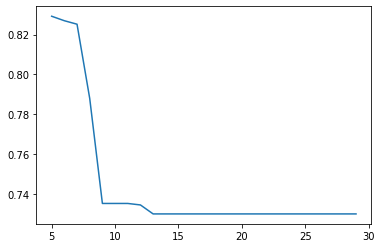

In [75]:
answer = np.array([np.mean(cross_val_score(MyDecisionTreeClassifier(criterion = best_criterion, 
                                                                    min_samples_split = 10,
                                                                    max_depth = depth), X, y, cv = 5))
                   for depth in tqdm(range(5,30))])
plt.plot(range(5, 30), answer)

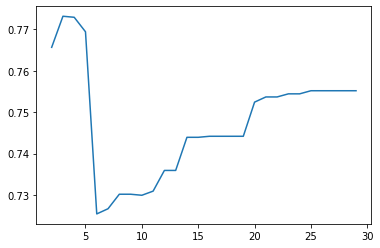

In [76]:
answer = np.array([np.mean(cross_val_score(MyDecisionTreeClassifier(criterion = best_criterion, max_depth = 20,
                                                                    min_samples_split = samples), X, y, cv = 5))
                   for samples in range(2,30)])
plt.plot(range(2, 30), answer)

In [77]:
best_score = 0
for depth in range(5, 15):
    for samples in range(2, 15):
        scr = np.mean(cross_val_score(MyDecisionTreeClassifier(criterion = best_criterion, 
                                                         min_samples_split = samples), X, y, cv = 5))
        if scr > best_score:
            
            best_depth = depth
            best_samples = samples
            best_score = scr

In [78]:
best_depth, best_samples, best_score

(5, 2, 0.8302105757196496)

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [79]:
my_clf = MyDecisionTreeClassifier(criterion = 'entropy', max_depth = 3, min_samples_split = 2).fit(X, y)
indx = np.argsort(my_clf.feature_importances_)[-10:]
my_best10 = {a: b for a, b in zip(df_pair.drop('match', axis=1).columns[indx], my_clf.feature_importances_[indx])}

In [81]:
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10, min_samples_split = 2).fit(X, y)
indx = np.argsort(clf.feature_importances_)[-10:]
best10 = {a: b for a, b in zip(df_pair.drop('match', axis=1).columns[indx], clf.feature_importances_[indx])}

In [82]:
my_best10

{'intel2_1': 0.0,
 'amb2_1': 0.0,
 'shar2_1': 0.0,
 'amb3_1_f': 0.017044317420497605,
 'shar1_1_f': 0.020293127747501895,
 'intel1_1': 0.028836410379126074,
 'exphappy_f': 0.030522537872484934,
 'age_f': 0.057958619598642576,
 'sinc2_1_f': 0.10699054045093664,
 'fun2_1': 0.7383544465308104}

In [83]:
best10

{'intel2_1': 0.03168603065952565,
 'fun1_1': 0.03173679476039464,
 'go_out': 0.03231900401370504,
 'shar1_1_f': 0.03367498224499186,
 'sinc2_1': 0.03385122995887322,
 'mn_sat_f': 0.035461178923713664,
 'attr2_1_f': 0.038545029487964615,
 'imprace': 0.03913751156460408,
 'imprelig_f': 0.043090385759138525,
 'int_corr': 0.05249739940820983}

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



In [ ]:
print('Все норм, побольше бы задач на терию, с ней интересней')